# Advanced Graph Server Example

In [1]:
import mlrun

> 2021-01-09 00:50:19,759 [warning] Failed resolving version info. Ignoring and using defaults
> 2021-01-09 00:50:20,990 [warning] Unable to parse server or client version. Assuming compatible: {'server_version': 'unstable', 'client_version': 'unstable'}


## Define function classes (will be used in our graph)

In [2]:
class ModelClass(mlrun.serving.V2ModelServer):
    def load(self):
        print("loading")

    def predict(self, request):
        print("predict:", request)
        resp = request["inputs"][0] * self.get_param("multiplier")
        return resp

class BaseClass:
    def __init__(self, context, name=None, **kw):
        self.context = context
        self.name = name
        self.kw = kw

class Echo(BaseClass):
    def do(self, x):
        print("Echo:", self.name, x)
        return x

class EchoError(BaseClass):
    def do(self, x):
        x.body = {"body": x.body, "origin_state": x.origin_state, "error": x.error}
        print("EchoError:", x)
        return None

In [3]:
# nuclio: end-code

## Create a new function and graph

In [4]:
function = mlrun.code_to_function("advanced", kind="serving", image="mlrun/mlrun")
graph = function.set_topology("flow", engine="async")

In [5]:
path1 = '.'
path2 = '.'
#function.verbose = True

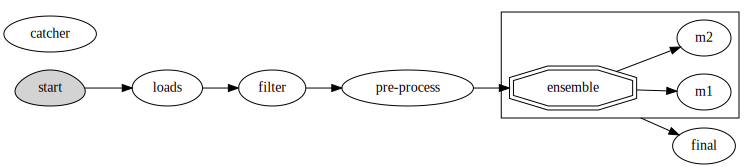

In [9]:
graph.error_handler("catcher")

graph.to(name="loads", handler="json.loads") \
     .to("storey.Filter", name="filter", _fn='(not hasattr(event, "inputs"))') \
     .to(class_name="Echo", name="pre-process", some_arg='abc')

# add an Ensemble router with two child models (routes), the "*" prefix mark it is a router class
router = graph.add_step("*mlrun.serving.routers.VotingEnsemble", name="ensemble", after="pre-process")
router.add_route("m1", class_name="ModelClass", model_path=path1, multiplier=2)
router.add_route("m2", class_name="ModelClass", model_path=path2, multiplier=3)

# add the final step (after the router) which handles post processing and respond to the client
graph.add_step(class_name="Echo", name="final", after="ensemble").respond()

# add error handling state, run only when/if the "loads" state fail (keep after="")  
graph.add_step(class_name="EchoError", name="catcher", full_event=True, after="")

# plot the graph (using Graphviz) and run a test
graph.plot(rankdir='LR')

## Test our function locally

In [ ]:
server = function.to_mock_server()
resp = server.test("/v2/models/m2/infer", body='{"inputs": [5]}')
server.wait_for_completion()
resp